<a href="https://colab.research.google.com/github/vorobieva/PDesign_workshop_Day1_RosettaDDG/blob/main/ddG_notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*
This notebook was developed based on the original notebook by Andrei Sokolovskii (andrei.sokolovskii@vub.be)

## The Heatmap
We will learn how to perform in silico mutational scanning to generate a heatmap like the one below.

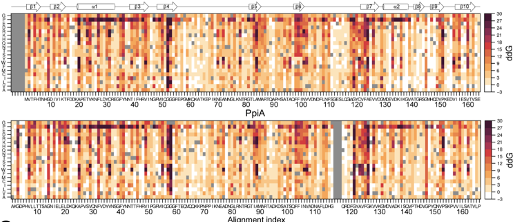

## ΔΔG Part 1: folding free energy calculations (monomeric protein)

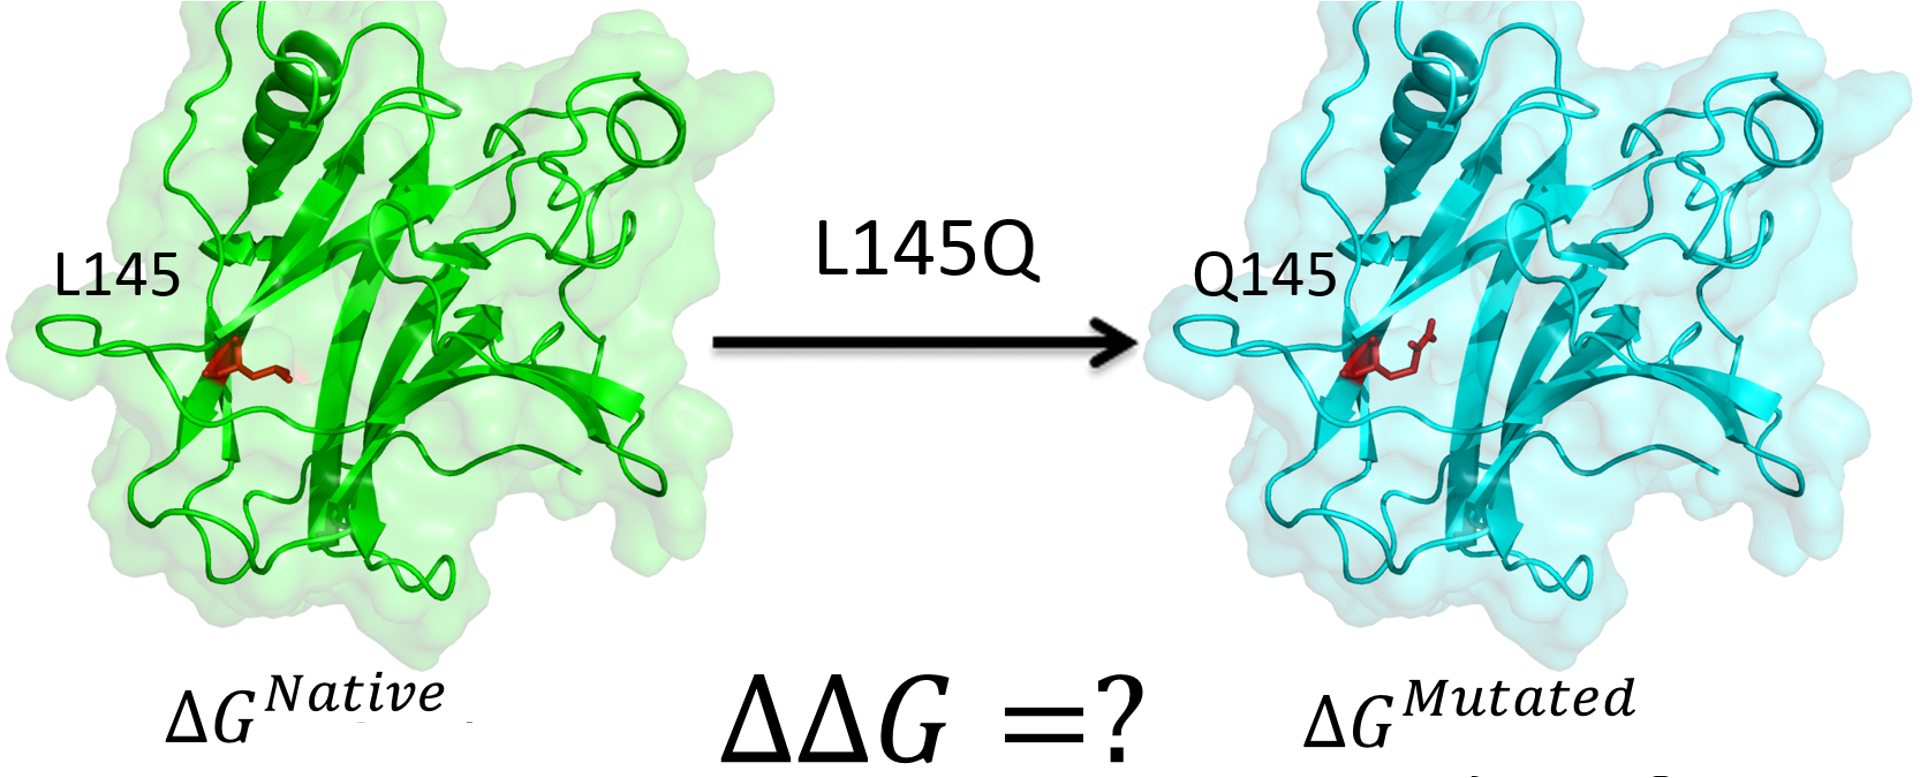

Accurately estimating the thermodynamic effect of a mutation is a key to protein engineering and design. In this exercise, we will scan all possible permutations in a small protein to try to find stabilizing mutations. To achieve this, we will carry out "alchemical" mutations during simulations and compute the corresponding free energy changes. By computing the folding free energy of the wild type protein and each mutant, we can assess the effect of mutations by substracting theyr folding free energy from that of the wild type, as shown below:

$$
\begin{align}
\Large {\Delta}{\Delta}G = {\Delta}G_{fold_{MT}} - {\Delta}G_{fold_{  WT}}
\end{align}
$$

## Objectives
1. Setup parameters
2. Prepare files and relax the PDB structure
3. Compute the ∆∆G of mutation
4. Analyze contributions to the change in stability
5. Visualize the model in PyMOL

### <u>To run jobs you need to load some modules</u> :
Python modules are small libraries of code designed for specific purpose or task. They facilitate code sharing and re-use by developers worldwide.
    
The first block of code on top of a Python script is usually meant to import the necessary modules. You will need to re-import the modules every time you disconnect/reconnect your Google Colab environment.
    
### <u>Module to load </u>
Proper work with the notebook requires the following modules:
1. PyRosetta
2. SciPy-bundle
3. matplotlib
4. Seaborn

In [ ]:
#@title Install and import pyrosetta - the molecular modelling software
!pip install pyrosettacolabsetup
import pyrosettacolabsetup; pyrosettacolabsetup.install_pyrosetta()
import pyrosetta; pyrosetta.init()

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2025 [Rosetta PyRosetta4.MinSizeRel.python311.ubuntu 2025.19+release.1354d05daa4c339d591afeecef3c94ca2d38680e 2025-05-07T12:36:04] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.MinSizeRel.python311.ubuntu r400 2025.19+release.1354d05daa 1354

In [ ]:
#@title First, we import the necessary Python modules
!pip install BioPython
!pip install py3Dmol
from google.colab import files
import Bio
import os
import glob
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import multiprocessing
multiprocessing.cpu_count()

2

## Preparation of the files

At this moment the following file structure should be present:
- ddG_notebook.ipynb
- PDB_filename.pdb

## Relaxation
The structure must be **relaxed** before it can be used for free energy calculations. Relaxing means minimizng the energy by sidechains repacking and backbone minimzation (simulated annealing) to make sure the input structure represents the lowest energy state. We will use coordinate retraints to make sure the output structure is almost identical to the input PDB structure. Typically, this step requires running several independent trajectories and picking the lowest energy output.



In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/google_drive')
pathWD="/content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/"

pose = pyrosetta.pose_from_pdb( pathWD+"peptide.pdb")

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).
core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 985 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 1.01663 seconds.
core.import_pose.import_pose: File '/content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/peptide.pdb' automatically determined to be of type PDB from contents.
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 1 in file /content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/peptide.pdb. Best match rsd_type:  LEU:NtermProteinFull
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 2 in file /content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/peptide.pdb. Best match rsd_type:  TYR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 5 atoms at position 3 in file 

In [ ]:
#@title The code below runs a "relax protocol" to prepare the PDB file for the calculations

relaxPose = pose.clone()
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        <ScoreFunction name="SFX1" weights="ref2015_cart">
           <Reweight scoretype="coordinate_constraint" weight="1.0"/>
        </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
           <AtomCoordinateCstMover name="coord_cst" />
           <FastRelax name="relax" cartesian="true" scorefxn="SFX1" />
        </MOVERS>
        <APPLY_TO_POSE/>
        <PROTOCOLS>
           <Add mover= "coord_cst"/>
           <Add mover="relax" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")
xml.apply(relaxPose)
relaxPose.dump_pdb(pathWD+'relaxed_peptide.pdb')

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Generating XML Schema for rosetta_scripts...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Initializing schema validator...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsParser: ...done
protocols.rosetta_scripts.RosettaScriptsParser: Parsed script:
<ROSETTASCRIPTS>
	<SCOREFXNS>
		<ScoreFunction name="SFX1" weights="ref2015_cart">
			<Reweight scoretype="coordinate_constraint" weight="1.0"/>
		</ScoreFunction>
	</SCOREFXNS>
	<RESIDUE_SELECTORS/>
	<TASKOPERATIONS/>
	<FILTERS/>
	<MOVERS>
		<AtomCoordinateCstMover name="coord_cst"/>
		<FastRelax cartesian="true" name="relax" scorefxn="SFX1"/>
	</MOVERS>
	<APPLY_TO_POSE/>
	<PROTOCOLS>
		<Add mover="coord_cst"/>
		<Add mover="relax"/>
	</PROTOCOLS>
</ROSETTASCRIPTS>
core.scoring.

True

This steps generates a new PDB file in your Google drive folder, which is now called "relaxed_peptide.pdb". To visualize the difference between the original PDB and the relaxed PDB structure, you can: (A) download the PDB files from Google Drive to open it on your laptop; or (B) go to the bottom of this notebook to use the integrated structure visualization tool.

## Scoring
Let's compare the calculated energy (score) of the relaxed structure to the input PDB.

In [ ]:
scorefxn = pyrosetta.get_score_function()
print("\nOld Energy:", scorefxn(pose),"\n")
print("\nNew Energy:", scorefxn(relaxPose),"\n")


core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015

Old Energy: 44.13035125531397 


New Energy: -45.38584671858516 



## Mutfile's preparation
We obtain the relaxed protein structure that is now prepared for mutational scanning.

We have to create new subfolders for each mutation, each containing a __mutfile__
<br><br>

Each __mutfile__ consists the following lines:

total 1 &emsp;# this is the total number of mutations being made.
<br>
1 &emsp; &emsp;&emsp;#the number of mutations
<br>
G 1 A &emsp; # the wild-type aa, the residue number, and the mutant aa


In the list below, add or remove positions to mutate and amino acids to mutated them to

In [ ]:
mut = ['L1', 'Y2', 'I3', 'Q4', 'W5', 'L6', 'K7', 'D8']
aa_list = ['M', 'F','G', 'A', 'I', 'P', 'S']

In [ ]:
#@title The code below prepares the folder for design calculations.

import shutil

mutations = []

for aa in range(0, len(mut)):
    pos = mut[aa]
    AA = mut[aa][0]
    if not os.path.exists(pathWD+"mutations/"+pos):
        os.makedirs(pathWD+"mutations/"+pos)
    for m in aa_list:
        if m != AA:
            mutation = pos+m
            mutations.append(mutation)
            if not os.path.exists(pathWD+"mutations/"+pos+"/"+mutation):
                os.makedirs(pathWD+"mutations/"+pos+"/"+mutation)
            with open(pathWD+"mutations/"+pos+"/"+mutation+"/mutfile",'w') as mut_file:
                mut_file.write("total 1\n")
                mut_file.write("1\n")
                mut_file.write("%s %d %s\n" %(AA, int(mut[aa][1:]), m))

#The code below copies your relaxed pdb into the mutations folder. You can change the name of the relaxed pdb if needed
shutil.copyfile(pathWD+'relaxed_peptide.pdb', pathWD+'mutations/relaxed_peptide.pdb')


'/content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/mutations/relaxed_peptide.pdb'

## ${\Delta}{\Delta} G$ calculation
In the next cell we will initialize two funciton.

def __ddg_job__ is made for estimating $\Delta\Delta G$ per one-point mutation.

def __run_ddg_calc_parallel__ is wrapper function for running calculation in parallel.

In [ ]:
#@title Preparative code ... class definition

class configs(object):
  def __init__(self):

    self.PDB_filename = pathWD+'relaxed_peptide.pdb'
    self.mut = mut
    self.aa_list = aa_list
    self.jobname = 'jobname_peptide'

    self.num_threads = 2
    self.ntraj = 20
    self.nstruct = 2
    self.relax_scorefxn = 'ref2015_cart'
    self.ddg_iterations = 3
    self.force_iterations = False
    self.ddg_score_cutoff = 1.0
    self.ddg_dump_pdbs = True
    self.ddg_bbnbrs = 1
    self.fa_max_dis = 9.0
    self.ddg_scorefxn = 'ref2015_cart'

    if not os.path.exists(self.PDB_filename):
        raise Exception(f"Sorry, the file with name {self.PDB_filename[:-4]} was not found.")

    if self.num_threads == 0:
        nslots = int(multiprocessing.cpu_count())
        self.num_threads = nslots
    self.coord_cst = True
    py_flags = "-ddg:mut_file mutfile -ddg:iterations "
    py_flags += str(self.ddg_iterations)
    py_flags += " -force_iterations "
    py_flags += str(self.force_iterations).lower()
    py_flags += " -ddg::score_cutoff "
    py_flags += str(self.ddg_score_cutoff)
    py_flags += " -ddg::cartesian -ddg::dump_pdbs "
    py_flags += str(self.ddg_dump_pdbs).lower()
    py_flags += " -ddg:bbnbrs "
    py_flags += str(self.ddg_bbnbrs)
    py_flags += " -fa_max_dis "
    py_flags += str(self.fa_max_dis)
    py_flags += " -score:weights "
    py_flags += str(self.ddg_scorefxn)
    py_flags += ".wts"
    self.py_flags = py_flags
    self.working_dir = pathWD

  def back(self):
        os.chdir(self.working_dir)

conf = configs()

In [ ]:
#@title Preparative code ... functions definitions

def ddg_job(args):
    pdb_name, py_flags, dest = args
    os.chdir(dest)
    print(os.getcwd())
    logging.basicConfig(filename='stdout.txt', level=logging.INFO)

    pose = pyrosetta.pose_from_pdb(pdb_name)
    pyrosetta.rosetta.protocols.ddg.CartesianddG.run(pose)
    os.chdir('../../')
    return 0

def run_ddg_calc_parallel(conf):
    conf.back()
    os.chdir(f'mutations')
    name = conf.PDB_filename
    num_th = conf.num_threads
    args = [(name, conf.py_flags, x[:-7]) for x in glob.glob('*/*/mutfile')]

    pyrosetta.init(conf.py_flags)
    with Pool(num_th) as pool:
        pool.map(ddg_job, args, chunksize=1)
    os.chdir('../../')
    return 0


Now, we will run ΔΔG calculation for all one-point mutations that were selected.

NOTE: This step will take a lot of time! You can skip it and proceed to the bottom of the notebook to use pre-computed results.

In [ ]:
#@title Run the DDG calculations

from multiprocessing.pool import Pool

run_ddg_calc_parallel(conf)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
protocols.relax.FastRelax: CMD: coord_cst_weight  -62.7587  0.0391948  0.0391948  0.02805
protocols.relax.FastRelax: CMD: scale:fa_rep  -54.9192  0.0391948  0.0391948  0.14575
core.pack.task: Packer task: initialize from command line()
protocols.relax.FastRelax: CMD: repack  -54.9957  0.038262  0.038262  0.14575
core.pack.pack_rotamers: built 209 rotamers at 17 positions.
core.pack.interaction_graph.interaction_graph_factory: Instantiating DensePDInteractionGraph
protocols.relax.FastRelax: CMD: scale:fa_rep  -54.4537  0.038262  0.038262  0.154
protocols.relax.FastRelax: CMD: repack  -54.9201  0.0391948  0.0391948  0.14575
protocols.relax.FastRelax: CMD: scale:fa_rep  -54.374  0.0391948  0.0391948  0.154
protocols.relax.FastRelax: CMD: min  -57.9026  0.0225932  0.0225932  0.154
protocols.relax.FastRelax: CMD: coord_cst_weight  -57.9026  0.0225932  0.0225932  0.154
protocols.relax.FastRelax: CMD: scale:fa_rep  

KeyboardInterrupt: 

Let's analyze just generated outputs. We are intrested in __mutfile.ddg__  files.

The __jobname__ folder structure now is looking like this:

- __jobname__
    - PDB_filename_clean.pdb
    - __$i^{th}$ trajectory folder__
        - stdout.txt
        - PDB_filename_*.pdb
        - PDB_filename.fasc
    - __mutations__
        - relaxed_PDB_filename_clean_$i$.pdb
        - __$i^{th}$__ mutation folder along __mut__ array
            - __$j^{th}$__ resulted mut folder along __aa_list__
                - mutfile
                - mutfile.ddg
                - stdout.txt
    
Based on the information from __mutfile.ddg__, the $\Delta\Delta G$ will be calculated as follows:

$$
\begin{align}
\Large{\Delta}{\Delta}G={\frac {\sum_{i}^{} MUT\_total\_score_{i} \\}{ddg\_iterations} }-{\frac {\sum_{i}^{} WT\_total\_score_{i} \\}{ddg\_iterations} }
\end{align}
$$


## Analyzing
The bellow function generates __*.csv__ file in root directory with $\Delta\Delta G$ values measured in REU. Today, we won't run this scriipt because we probably have not had the time to process all the mutations. Instead, go to the next cell to work with a pre-computed result file.

In [ ]:
#@title If you ran the ddG calculations to completion, you can run the code below to calculate the predicted ddGs based on the formula above. Otherwise, go to the next step

def analyze_ssm(conf):
    conf.back()
    mut = conf.mut
    aa_list = conf.aa_list
    import os
    import glob
    import numpy as np
    os.chdir(pathWD+'/mutations')
    def nice_order(aa_l):
        nice_order_for_heatmap  = ["G","P","E","D","R","K","H","Q","N","T","S","Y","W","F","M","C","I","L","V","A"]
        aa_list_for_an = nice_order_for_heatmap.copy()
        for item in nice_order_for_heatmap:
            if item not in aa_l:
                aa_list_for_an.remove(item)
        return aa_list_for_an
    aa_list = nice_order(aa_list)
    ala_scan = {}
    ssm = np.zeros([len(aa_list), len(mut)], dtype=float)

    for aa in range(0, len(mut)):
        pos = mut[aa]
        AA = mut[aa][0]
        for i in range(0, len(aa_list)):
            amino_acid = aa_list[i]
            if AA != amino_acid:
                mutation = mut[aa]+amino_acid
                n_WT = 0
                n_MUT = 0
                score_WT = 0
                score_MUT = 0
                with open(pos+"/"+mutation+"/mutfile.ddg", 'r') as mutfile:
                    for line in mutfile:
                        if "WT" in line:
                            score = float(line.split()[3])
                            n_WT += 1
                            score_WT += score
                        elif "MUT_" in line:
                            score = float(line.split()[3])
                            n_MUT += 1
                            score_MUT += score
                score_WT = score_WT/n_WT
                score_MUT = score_MUT/n_MUT
                ddG = score_MUT - score_WT
                ssm[i,aa] = float(ddG)


    np.savetxt(f"../../{conf.jobname}_SSM_ddg.csv", ssm, delimiter=",")
    os.chdir('../../')
    return 0
analyze_ssm(conf)

Once the *SSM_ddg.csv* file is obtained, we can finally plot heatmap and detect which mutation and where could stabilize the protein. IF YOU SKIPPED THE CALCULATIONS ABOVE TO SAVE TIME, HERE IS WHER YOU CAN RESTART.

In [ ]:
#@title Path to find the SSM data. This is currently set to the path to the pre-computed dataset
ssm_file=pathWD+"/precomputed_results/SSM_ddg.csv"

In [ ]:
#@title This is a list of residues in the peptide and of amino acids. For formatting purpose only!
mut = ['L1', 'Y2', 'I3', 'Q4', 'W5', 'L6', 'K7', 'D8', 'G9', 'G10', 'P11', 'S12', 'S13', 'G14', 'R15', 'P16', 'P17', 'P18']
aa_list = ['M','F','Y','V','L','W','G','A','I','P','S','T','Q','N','R','K','E','D','C','H']

['G', 'P', 'E', 'D', 'R', 'K', 'H', 'Q', 'N', 'T', 'S', 'Y', 'W', 'F', 'M', 'C', 'I', 'L', 'V', 'A']


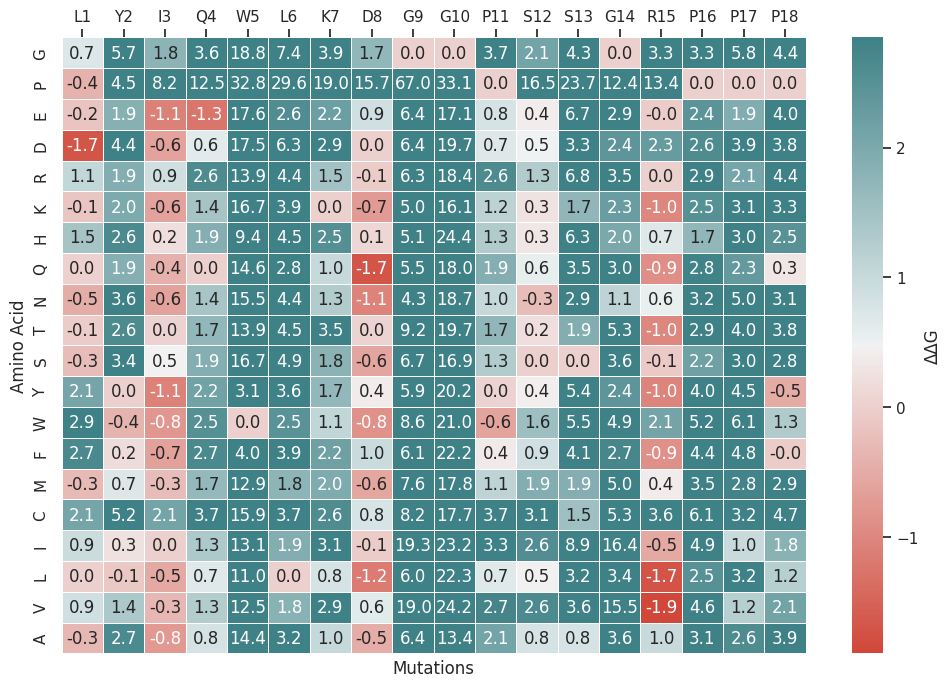

In [ ]:
#@title The code below generates a heatmap to visualize the results. See below for tips to customize the figure

def plot_heatmap(ssm_file):
    def nice_order(aa_l):
        nice_order_for_heatmap  = ["G","P","E","D","R","K","H","Q","N","T","S","Y","W","F","M","C","I","L","V","A"]
        aa_list_for_an = nice_order_for_heatmap.copy()
        for item in nice_order_for_heatmap:
            if item not in aa_l:
                aa_list_for_an.remove(item)
        return aa_list_for_an
    a_list = nice_order(aa_list)
    print(a_list)
    df_ddg = pd.read_csv(ssm_file, header=None)
    rows = {i:a_list[i] for i in range(len(a_list))}
    columns = {i:mut[i] for i in range(len(mut))}

    df_ddg = df_ddg.rename(columns=columns)
    df_ddg = df_ddg.rename(index=rows)
    minc = df_ddg.min().min()
    range_color = [minc, (-1.5) * minc]
    sns.set (rc = {'figure.figsize':(12, 8)})
    ax = sns.heatmap(df_ddg,  cmap=sns.diverging_palette(15, 200, as_cmap=True), annot=True, fmt=".1f",linewidth=.5, vmin = minc, vmax = (-1.5) * minc, \
                     cbar_kws={'label': 'ΔΔG', 'orientation': 'vertical'})#, annot_kws={"size": 20}
    ax.set(xlabel="Mutations", ylabel="Amino Acid")
    ax.xaxis.tick_top()

plot_heatmap(ssm_file)

You can change the color and looks of the heatmap by looking in the pyplot documentation for the right commands:
https://matplotlib.org/stable/users/explain/colors/colormaps.html

**Bonus: visualize proteins in the notebook instead of Pymol**


In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol

show_original = True #@param {type:"boolean"}
show_sidechains = True #@param {type:"boolean"}
color = "rainbow" #@param ["chain", "rainbow"]


view=py3Dmol.view()

def show_pdb(show_sidechains=False, show_original=False, color="chain"):
  view.addModel(open(pathWD+'relaxed_peptide.pdb', 'r').read(),'pdb')
  view.setBackgroundColor('white')

  if show_original:
    view.addModel(open(pathWD+'peptide.pdb', 'r').read(),'pdb')

  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = pose.num_chains()#len(queries[0][1]) + 1 if is_complex else 1
    pymol_color_list = ['skyblue', 'yellow', 'green', 'magenta']
    alphabet_list = ['A', 'B', 'C', 'D']

    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})


  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})


  view.zoomTo()
  return view

show_pdb(show_sidechains, show_original, color).show()
#view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## ΔΔG Part 2: interaction free energy calculations (protein complex)

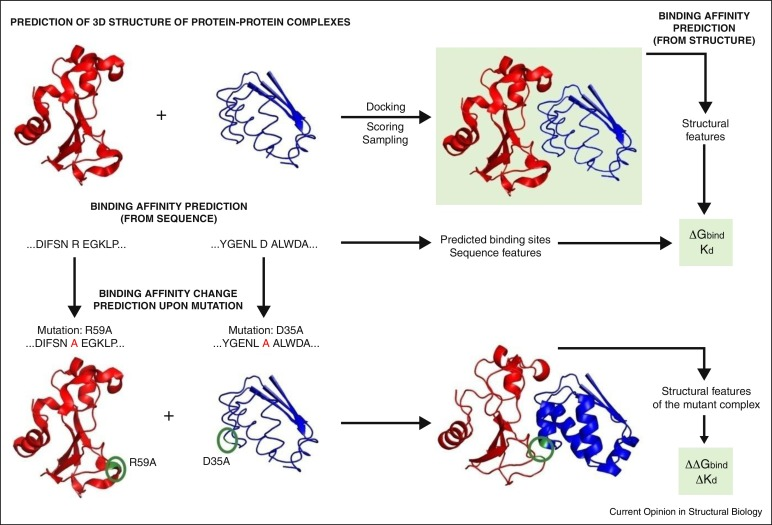

Image taken from: https://doi.org/10.1016/j.sbi.2016.10.016

*This section is adapted from the Pyrosetta teaching notebooks, developed by Yuanhan Wu (The Wistar Institute), Daniel Kulp (The Wistar Institute), Jared Adolf-Bryfogle (Scripps; Institute for Protein Innovation) and Ajasja Ljubetič (University of Washington)*

Another important problem in protein engineering is how to accurately estimate the effect of mutations on the interaction energy of two proteins. For example, considering a peptide binding to your protein of interest, you might want to predict which mutations in the peptide would result in stronger or weaker binding.

The principle of the interaction free energy calculations is similar to the principles outlined above. We are now considering the **binding free energy**, which is the difference between the individual free energies of the free interaction partners and the total energy of the complex according to the equation below. Starting from the PDB structure of the complex, we compute its total energy. The proteins in the complex are then pull apart to calculate the sum of their individual energies. The same simulations are used to calculate the binding free energy of the complex in the presence of  mutations. The final ΔΔG*binding* is the **difference in binding free energy of the WT complex and the mutated complex**.


$$
\begin{align}
\Large {\Delta}{\Delta}G = ∑{\Delta}G_{monomers} - {\Delta}G_{complex}
\end{align}
$$

Our model system will be GLP-1 (Glucagon-Like peptide 1). It is a hormone that plays a crucial role in regulating blood sugar and appetite. It's produced in the small intestine and stimulates insulin release from the pancreas, helping to lower blood sugar levels after eating. GLP-1 also slows down digestion and can help reduce appetite. Its natural binding partner is the Glucagon-Like Peptide-1 (GLP-1) Receptor, a GPCR. The recently developed weight loss blockbuster drugs (e.g. Ozempic) are engineered peptides that act like GLP-1 receptor agonists and mimick the effects of GLP-1. GLP-1 and its receptors are therefore very important drug development targets.

In [ ]:
#@title Importing the PDB structure (derived from PDB ID 6x18) {run: "auto"}

from pyrosetta.toolbox import cleanATOM

pathWD="/content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/"

cleanATOM(pathWD+"GLP_complex.pdb")
pose_glp = pyrosetta.pose_from_pdb(pathWD+"GLP_complex.clean.pdb")


core.import_pose.import_pose: File '/content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/GLP_complex.clean.pdb' automatically determined to be of type PDB from contents.
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  O   in residue 34 A.  Pass flag -ignore_zero_occupancy false to change this behavior
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  CG  in residue 64 B.  Pass flag -ignore_zero_occupancy false to change this behavior
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  CD  in residue 64 B.  Pass flag -ignore_zero_occupancy false to change this behavior
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  NE  in residue 64 B.  Pass flag -ignore_zero_occupancy false to change this behavior
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] PDB reader is ignoring atom  CZ  in residue 64 B.  Pass flag -ignore_zero_occupancy false to chang

In [ ]:
#@title **STOP HERE and think before running this box!** This code runs the "relax protocol" to prepare the PDB file for the calculations. **Note: This step takes a lot of time! You can also skip this cell and go to the next one, which uses a pre-computed model.**

relaxPose = pose_glp.clone()
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
    <ROSETTASCRIPTS>
        <SCOREFXNS>
        <ScoreFunction name="SFX1" weights="ref2015_cart">
           <Reweight scoretype="coordinate_constraint" weight="1.0"/>
        </ScoreFunction>
        </SCOREFXNS>
        <RESIDUE_SELECTORS>
        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
        </TASKOPERATIONS>
        <FILTERS>
        </FILTERS>
        <MOVERS>
           <AtomCoordinateCstMover name="coord_cst" />
           <FastRelax name="relax" cartesian="true" scorefxn="SFX1" />
        </MOVERS>
        <APPLY_TO_POSE/>
        <PROTOCOLS>
           <Add mover= "coord_cst"/>
           <Add mover="relax" />
        </PROTOCOLS>
    </ROSETTASCRIPTS>
    """).get_mover("ParsedProtocol")
xml.apply(relaxPose)
relaxPose.dump_pdb(pathWD+'GLP_complex.clean.pdb')

protocols.rosetta_scripts.RosettaScriptsParser: Validating input script...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Generating XML Schema for rosetta_scripts...
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: ...done
protocols.rosetta_scripts.RosettaScriptsSchemaValidator: Initializing schema validator...


In [ ]:
#@title Here is a function to separate the two chains in the complex and computing the interaction energy

def unbind(pose, partners):
    STEP_SIZE = 100
    JUMP = 1
    pyrosetta.rosetta.protocols.docking.setup_foldtree(pose, partners, pyrosetta.Vector1([-1,-1,-1]))
    trans_mover = pyrosetta.rosetta.protocols.rigid.RigidBodyTransMover(pose,JUMP)
    trans_mover.step_size(STEP_SIZE)
    trans_mover.apply(pose)


##Reset the original pose
relaxPose = pyrosetta.pose_from_pdb(pathWD+"precomputed_results/GLP_complex.relax.pdb")
original = relaxPose.clone()

scorefxn = pyrosetta.get_score_function()
bound_score = scorefxn(relaxPose)
print("\nBound State Score",bound_score,"\n")
unbind(original, "A_B")
unbound_score = scorefxn(original)
original.dump_pdb(pathWD+'GLP_unbound.pdb')

print("\nUnbound State Score", unbound_score,"\n")
print('dG', bound_score - unbound_score, 'Rosetta Energy Units (REU)')

core.import_pose.import_pose: File '/content/google_drive/MyDrive/Pavia_course/Day1_RosettaDDG/precomputed_results/GLP_complex.relax.pdb' automatically determined to be of type PDB from contents.
core.conformation.Conformation: Found disulfide between residues 48 73
core.conformation.Conformation: Found disulfide between residues 64 106
core.conformation.Conformation: Found disulfide between residues 87 128
core.conformation.Conformation: Found disulfide between residues 222 292
core.scoring.ScoreFunctionFactory: SCOREFUNCTION: ref2015

Bound State Score -1215.307256553524 


Unbound State Score -1092.5700652924122 

dG -122.73719126111178 Rosetta Energy Units (REU)


In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol

show_sidechains = True #@param {type:"boolean"}
color = "chain" #@param ["chain", "rainbow"]
model = "bound" #@param ["bound", "unbound"]

view=py3Dmol.view()

def show_pdb(show_sidechains=False, color="chain", model="bound"):

  if model == "bound":
    view.addModel(open(pathWD+'precomputed_results/'+'GLP_complex.relax.pdb', 'r').read(),'pdb')
  elif model == "unbound":
    view.addModel(open(pathWD+'precomputed_results/'+'GLP_unbound.pdb', 'r').read(),'pdb')

  view.setBackgroundColor('white')

  if color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = pose_glp.num_chains()#len(queries[0][1]) + 1 if is_complex else 1
    pymol_color_list = ['skyblue', 'yellow', 'green', 'magenta', 'white', 'salmon']
    alphabet_list = ['A', 'B', 'C', 'D', 'E', 'F']

    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
      view.setStyle({'chain':chain},{'cartoon': {'color':color}})


  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(show_sidechains, color, model).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
#@title Creating the Rosetta packing function and running a quick test {run: "auto"}

def pack(pose, posi, amino, scorefxn):

    # Select Mutate Position
    mut_posi = pyrosetta.rosetta.core.select.residue_selector.ResidueIndexSelector()
    mut_posi.set_index(posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(mut_posi.apply(pose)))

    # Select Neighbor Position
    nbr_selector = pyrosetta.rosetta.core.select.residue_selector.NeighborhoodResidueSelector()
    nbr_selector.set_focus_selector(mut_posi)
    nbr_selector.set_include_focus_in_subset(True)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(nbr_selector.apply(pose)))

    # Select No Design Area
    not_design = pyrosetta.rosetta.core.select.residue_selector.NotResidueSelector(mut_posi)
    #print(pyrosetta.rosetta.core.select.get_residues_from_subset(not_design.apply(pose)))

    # The task factory accepts all the task operations
    tf = pyrosetta.rosetta.core.pack.task.TaskFactory()

    # These are pretty standard
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.InitializeFromCommandline())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.IncludeCurrent())
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.NoRepackDisulfides())

    # Disable Packing
    prevent_repacking_rlt = pyrosetta.rosetta.core.pack.task.operation.PreventRepackingRLT()
    prevent_subset_repacking = pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(prevent_repacking_rlt, nbr_selector, True )
    tf.push_back(prevent_subset_repacking)

    # Disable design
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(
        pyrosetta.rosetta.core.pack.task.operation.RestrictToRepackingRLT(),not_design))

    # Enable design
    aa_to_design = pyrosetta.rosetta.core.pack.task.operation.RestrictAbsentCanonicalAASRLT()
    aa_to_design.aas_to_keep(amino)
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.OperateOnResidueSubset(aa_to_design, mut_posi))

    # Create Packer
    packer = pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover()
    packer.task_factory(tf)

    #Perform The Move
    if not os.getenv("DEBUG"):
      packer.apply(pose)

#Load the previously-relaxed pose.
#relaxPose = pose_from_pdb(pathWD+"precomputed_results/GLP_complex.relax.pdb")

#Clone it
original = relaxPose.clone()
scorefxn = pyrosetta.get_score_function()
print("\nOld Energy:", scorefxn(relaxPose),"\n")
pack(original, 2, 'A', scorefxn)
print("\nNew Energy:", scorefxn(original),"\n")



Old Energy: -1215.307256553524 


New Energy: -1215.307256553524 



In [ ]:
#@title Creating the function to introduce mutations and running one quick test {run: "auto"}

Residue_number = "2" #@param [1, 2, 3, 4, 5]
Mutation = "A" #@param ['M','F','Y','V','L','W','G','A','I','P','S','T','Q','N','R','K','E','D','C','H']

three2one = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

def mutate(pose, posi, amino, partners):

    content = 'Mutation, native_bound_energy, native_unbound_energy, native_interaction_energy, mut_bound_energy, mut_unbound_energy, mut_interaction_energy, interaction_ddg\n'

    #Copy pose to do the mutation
    native = pose.clone()

    #Initiate energy function
    scorefxn = pyrosetta.get_fa_scorefxn()
    wt = three2one[pose.residue(posi).name()[:3]]
    wt_resi = three2one[pose.residue(posi).name()[:3]]+str(posi)

    pack(native, posi, wt, scorefxn)
    native_bnd = scorefxn(native)
    unbind(native, partners)
    native_ub = scorefxn(native)
    native_energy = native_ub - native_bnd

    if (wt == amino):
      binding = native_energy
      bound = native_bnd
      unbound = native_ub
      ddG = native_energy - binding

      dest = wt_resi+str(amino)+'/'

    else:
      pdbname = "MUT_"+str(posi)+str(amino)+'.pdb'
      dest = wt_resi+str(amino)+'/'

      pack(pose, posi, amino, scorefxn)
      pose.dump_pdb(pathWD+"mutations_complex/"+wt_resi + "/" +dest+pdbname)
      bound = scorefxn(pose)
      unbind(pose, partners)
      unbound = scorefxn(pose)
      binding = unbound - bound

      ddG = native_energy - binding

    print(native_energy, binding)

    content=content+('%s, %f, %f, %f, %f, %f, %f, %f\n' %("MUT_"+str(posi)+str(amino), native_ub, native_bnd, native_energy, unbound, bound, binding, ddG))
    print(content)
    name = pathWD+"mutations_complex/"+wt_resi + "/" + dest + "mutfile.ddg"
#    content=(content+str(pose.pdb_info().pose2pdb(posi))+','+str(amino)+','
#              +str(native_ub)+','+str(bound)+','+str(unbound)+','+str(binding)+','
#              +str(wt_energy)+','+str(wt)+','+str(binding/wt_energy)+'\n')

    f = open(name,'w')
    f.write(content)
    f.close()

original = relaxPose.clone()
mutate(original, int(Residue_number), Mutation, 'A_B')

122.73719126111382 122.73719126111382
Mutation, native_bound_energy, native_unbound_energy, native_interaction_energy, mut_bound_energy, mut_unbound_energy, mut_interaction_energy, interaction_ddg
MUT_2A, -1092.570065, -1215.307257, 122.737191, -1092.570065, -1215.307257, 122.737191, 0.000000



In [ ]:
#@title Run the interface ddG calculations {run: "auto"}
import shutil

chain = "A" #@param ["A", "B"]
mode = "AlaScan" #@param ["AlaScan", "MutScan"]

three2one = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'}

#NOTE - This takes a very long time!!
# You may skip this block to continue the tutorial with pre-configured outputs.
if not os.getenv("DEBUG"):
  if chain == 'A':
    amino = []
    resi_num = list(range(relaxPose.chain_begin(1), relaxPose.chain_end(1)+1))
    mut = [three2one[relaxPose.residue(i).name()[:3]]+str(i) for i in resi_num]

    if mode == "AlaScan":
      amino = ['A']
    elif mode == "MutScan":
      amino = ['M','F','Y','V','L','W','G','A','I','P','S','T','Q','N','R','K','E','D','C','H']

    for aa in mut:
      pos = int(aa[1:])
      AA = aa[0]
      if not os.path.exists(pathWD+"mutations_complex/"+aa):
        os.makedirs(pathWD+"mutations_complex/"+aa)

      for m in amino:
        mutation = aa+m
        if not os.path.exists(pathWD+"mutations_complex/"+aa+"/"+mutation):
          os.makedirs(pathWD+"mutations_complex/"+aa+"/"+mutation)

        original = relaxPose.clone()
        mutate(original, pos, m, 'A_B')

  elif chain == 'B':
    print("You currently don't have enough computing power to mutate chain B. Please change chain to A.")


122.73719126111291 117.51350288328331
Mutation, native_bound_energy, native_unbound_energy, native_interaction_energy, mut_bound_energy, mut_unbound_energy, mut_interaction_energy, interaction_ddg
MUT_1A, -1092.570065, -1215.307257, 122.737191, -1092.784551, -1210.298054, 117.513503, 5.223688

122.73719126111382 122.73719126111382
Mutation, native_bound_energy, native_unbound_energy, native_interaction_energy, mut_bound_energy, mut_unbound_energy, mut_interaction_energy, interaction_ddg
MUT_2A, -1092.570065, -1215.307257, 122.737191, -1092.570065, -1215.307257, 122.737191, 0.000000

122.73719126111382 118.5391613380234
Mutation, native_bound_energy, native_unbound_energy, native_interaction_energy, mut_bound_energy, mut_unbound_energy, mut_interaction_energy, interaction_ddg
MUT_3A, -1092.570065, -1215.307257, 122.737191, -1091.905835, -1210.444997, 118.539161, 4.198030

122.73719126111291 123.43136759971594
Mutation, native_bound_energy, native_unbound_energy, native_interaction_energ

{'H1': [5.223688], 'A2': [0.0], 'E3': [4.19803], 'G4': [-0.694176], 'T5': [3.395249], 'F6': [7.345202], 'T7': [2.917763], 'S8': [1.48673], 'D9': [3.055662], 'V10': [1.951009], 'S11': [-2.753012], 'S12': [-0.504658], 'Y13': [4.753847], 'L14': [2.024299], 'E15': [5.487373], 'G16': [-0.196936], 'Q17': [1.28772], 'A18': [0.0], 'A19': [0.0], 'K20': [2.206916], 'E21': [0.089585], 'F22': [8.224868], 'I23': [4.689166], 'A24': [0.0], 'W25': [4.74242], 'L26': [4.131898], 'V27': [2.255696], 'K28': [-0.0], 'G29': [-0.254782], 'R30': [4.268913]}


<ipython-input-131-d3d5fff221c6>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new], ignore_index=True)


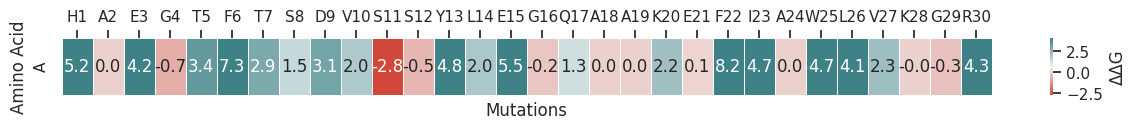

In [ ]:
#@title Let's first plot the results of the Alanine Scaning {run: "auto"}

mut = ['H1', 'A2', 'E3', 'G4', 'T5', 'F6', 'T7', 'S8', 'D9', 'V10', 'S11', 'S12', 'Y13', 'L14', 'E15', 'G16', 'Q17', 'A18', 'A19', 'K20', 'E21', 'F22', 'I23', 'A24', 'W25', 'L26', 'V27', 'K28', 'G29', 'R30']
amino = ['A']
df = pd.DataFrame(columns=mut)

for aa in amino:
  mutations = {}
  for m in mut:
    dest = m+aa+"/"
    ddg_file = pathWD+"mutations_complex/"+m + "/" + dest + "mutfile.ddg"
    dd = pd.read_csv(ddg_file, sep=",")
    mutations[m] = [float(dd[' interaction_ddg'][0])]
  print(mutations)
  new = pd.DataFrame.from_dict(mutations)
  df = pd.concat([df, new], ignore_index=True)

rows = {i:amino[i] for i in range(len(amino))}
df = df.rename(index=rows)
minc = df.min().min()
range_color = [minc, (-1.5) * minc]
sns.set (rc = {'figure.figsize':(15, 0.75)})
ax = sns.heatmap(df,  cmap=sns.diverging_palette(15, 200, as_cmap=True), annot=True, fmt=".1f",linewidth=.5, vmin = minc, vmax = (-1.5) * minc, \
                     cbar_kws={'label': 'ΔΔG', 'orientation': 'vertical'})#, annot_kws={"size": 20}
ax.set(xlabel="Mutations", ylabel="Amino Acid")
ax.xaxis.tick_top()


<ipython-input-133-d8d3a1f0fcc8>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new], ignore_index=True)


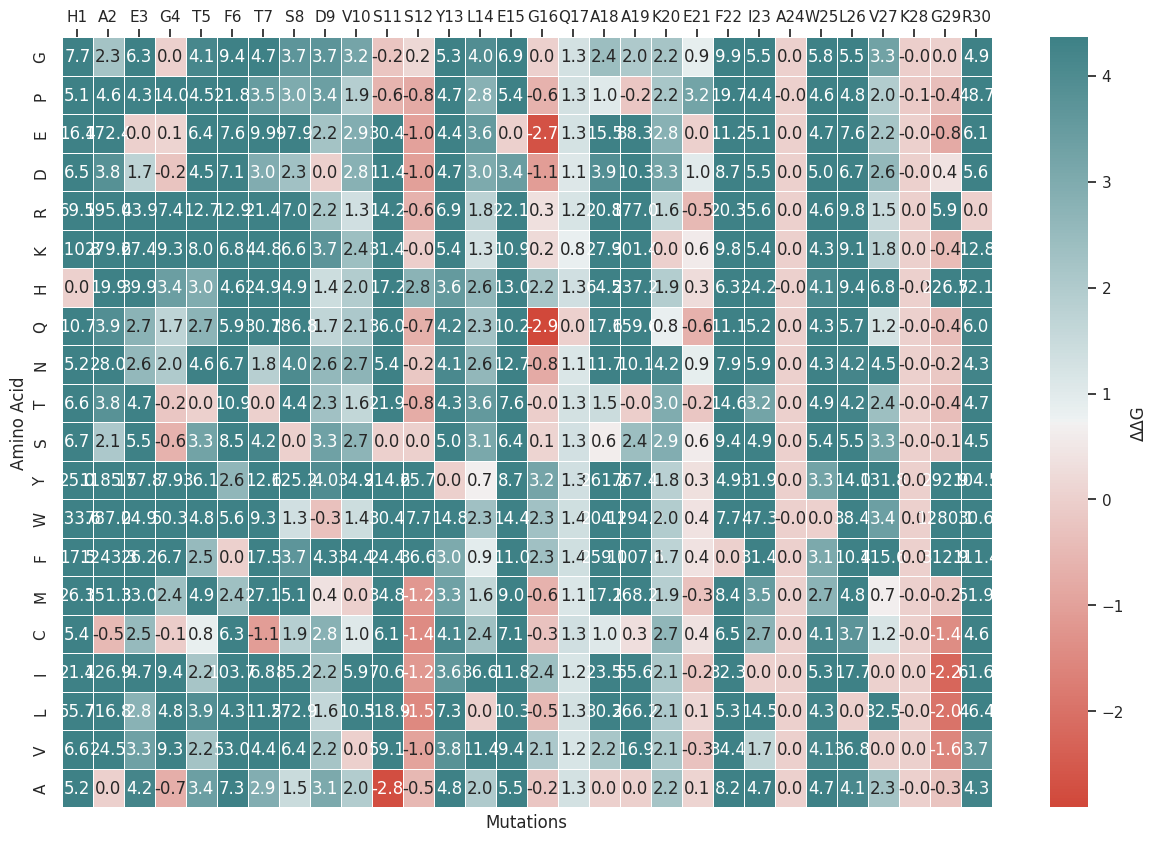

In [ ]:
#@title Finally, the scanning mutagenesis. What pattern do you see in the results? Open the PDB and try to find where beneficial mutations would be located. {run: "auto"}

mut = ['H1', 'A2', 'E3', 'G4', 'T5', 'F6', 'T7', 'S8', 'D9', 'V10', 'S11', 'S12', 'Y13', 'L14', 'E15', 'G16', 'Q17', 'A18', 'A19', 'K20', 'E21', 'F22', 'I23', 'A24', 'W25', 'L26', 'V27', 'K28', 'G29', 'R30']
amino = ["G","P","E","D","R","K","H","Q","N","T","S","Y","W","F","M","C","I","L","V","A"]
df = pd.DataFrame(columns=mut)

for aa in amino:
  mutations = {}
  for m in mut:
    dest = m+aa+"/"
    ddg_file = pathWD+"mutations_complex/"+m + "/" + dest + "mutfile.ddg"
    dd = pd.read_csv(ddg_file, sep=",")
    mutations[m] = [float(dd[' interaction_ddg'][0])]
  new = pd.DataFrame.from_dict(mutations)
  df = pd.concat([df, new], ignore_index=True)

rows = {i:amino[i] for i in range(len(amino))}
df = df.rename(index=rows)
minc = df.min().min()
range_color = [minc, (-1.5) * minc]
sns.set (rc = {'figure.figsize':(15, 10)})
ax = sns.heatmap(df,  cmap=sns.diverging_palette(15, 200, as_cmap=True), annot=True, fmt=".1f",linewidth=.5, vmin = minc, vmax = (-1.5) * minc, \
                     cbar_kws={'label': 'ΔΔG', 'orientation': 'vertical'})#, annot_kws={"size": 20}
ax.set(xlabel="Mutations", ylabel="Amino Acid")
ax.xaxis.tick_top()